In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from dataset import SiameseDataset

In [60]:
def normalize_heatmap(heatmap):
    heatmap -= heatmap.min()
    heatmap /= heatmap.max()
    return heatmap

def generate_heatmap(image_shape, landmarks, sigma=1.0, scale=1.0):
    k, H, W = image_shape
    heatmaps = np.zeros((k, H, W), dtype=np.float32)
    
    for idx, (x, y) in enumerate(landmarks):
        x_scaled = int(np.round(x * scale))
        y_scaled = int(np.round(y * scale))
        
        x_range = np.arange(0, W)
        y_range = np.arange(0, H)
        X, Y = np.meshgrid(x_range, y_range)
        
        heatmap = (1 / (2 * np.pi * sigma ** 2)) * np.exp(-((X - x_scaled) ** 2 + (Y - y_scaled) ** 2) / (2 * sigma ** 2))
        heatmaps[idx] = normalize_heatmap(heatmap)
    
    return heatmaps

In [61]:
def overlay_heatmaps(image, heatmaps, alpha=0.5, colormap=cv2.COLORMAP_HOT):
    overlayed_image = image.astype(np.float32)

    for heatmap in heatmaps:
        heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        heatmap_resized = cv2.normalize(heatmap_resized, None, 0, 1, cv2.NORM_MINMAX)
        heatmap_resized = np.power(heatmap_resized, 0.5)  # Increase contrast
        
        heatmap_normalized = (heatmap_resized * 255).astype(np.uint8)
        heatmap_colored = cv2.applyColorMap(heatmap_normalized, colormap).astype(np.float32)

        overlayed_image = cv2.addWeighted(overlayed_image, 1.0, heatmap_colored, alpha, 0)

    overlayed_image = np.clip(overlayed_image, 0, 255).astype(np.uint8)

    return overlayed_image

In [62]:
def apply_fifa_augmentation(image, landmarks, patch_size_start, epochs, interval):
    img_aug = image.copy()
    h, w, _ = image.shape
    
    for epoch in range(epochs):
        k = epoch // interval
        patch_size = max(1, patch_size_start - k)
        half_patch = patch_size // 2
        
        for (x, y) in landmarks:
            top_left = (int(x - half_patch), int(y - half_patch))
            bottom_right = (int(x + half_patch), int(y + half_patch))
            
            if (0 <= top_left[0] < w and 0 <= top_left[1] < h and
                0 <= bottom_right[0] < w and 0 <= bottom_right[1] < h):
                cv2.rectangle(img_aug, top_left, bottom_right, (0, 0, 0), -1)
    
    return img_aug

In [63]:
dataset = SiameseDataset(root_dir='archive/ibug_300W_large_face_landmark_dataset/afw')

In [64]:
img, imgMirror, points = dataset.__getitem__(1)

In [65]:
img_fifa_augmented = apply_fifa_augmentation(img, points, patch_size_start=10, epochs=5, interval=1)

In [66]:
heatmaps = generate_heatmap((len(points), img.shape[0], img.shape[1]), points)

In [67]:
img_with_heatmaps = overlay_heatmaps(img, heatmaps, alpha=0.6)

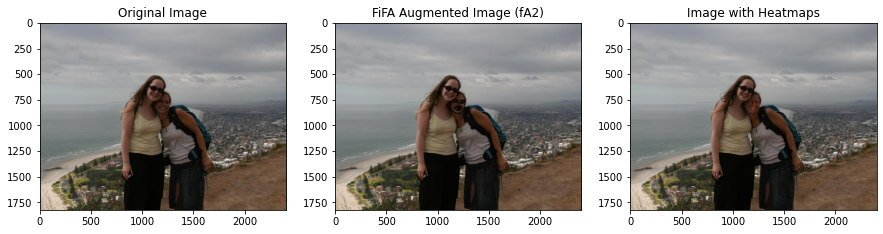

In [68]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img_fifa_augmented, cv2.COLOR_BGR2RGB))
plt.title('FiFA Augmented Image (fA2)')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img_with_heatmaps, cv2.COLOR_BGR2RGB))
plt.title('Image with Heatmaps')

plt.show()